# Import Libraries

In [210]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# Changing current working directory

In [3]:
import os
cwd = os.getcwd()
print (cwd)
%cd "C:\Users\rajus\Desktop\SameerSpring\SSS_BigData\Assignment1\Assignment1_Data"

C:\Users\rajus
C:\Users\rajus\Desktop\SameerSpring\SSS_BigData\Assignment1\Assignment1_Data


# Let's get the list of all the input files

In [211]:
from subprocess import check_output
print(check_output(["ls", "../Assignment1_Data"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
prior_df1.csv
products.csv
sample_submission.csv
xgb_starter_3450.csv



Read Inputs into data frame

In [213]:
order_products_train = pd.read_csv("../Assignment1_Data/order_products__train.csv")
order_products_prior = pd.read_csv("../Assignment1_Data/order_products__prior.csv")
orders = pd.read_csv("../Assignment1_Data/orders.csv")
products = pd.read_csv("../Assignment1_Data/products.csv")
aisles = pd.read_csv("../Assignment1_Data/aisles.csv")
departments = pd.read_csv("../Assignment1_Data/departments.csv")

Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [5]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


display first five rows.

In [214]:


order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [215]:
#display first five rows. 

order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Now, let's concatenate them in the same order_products dataframe. This will concatenate all orders from previous customers plus new customers

In [216]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [217]:
#display first five rows.

order_products_all.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


 ## Missing Data in all orders 

In [218]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


There is no missing data in order_products_all dataset

## Summary Statistics

In [11]:
order_products_all.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,2.557551e+04,8.367738e+00,5.900617e-01
std,9.874008e+05,1.409770e+04,7.139540e+00,4.918220e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.554130e+05,1.351900e+04,3.000000e+00,0.000000e+00
50%,1.710660e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565587e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


With above result we can inference that there are no inappropriate values . We can safely infer that there is no leak

## Data Distribution

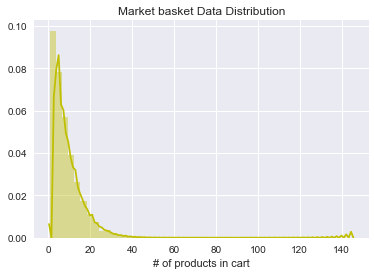

In [219]:
plt.title("Market basket Data Distribution")
sns.distplot(order_products_all.add_to_cart_order,axlabel="# of products in cart",color="y")


I am trying to analyze  data distribution by answering following questions: 
  
  * 1 How many are unique customer of Instacart
  * 2 How many number or product purchase average per customer?
  * 3 What is the reorder frequency?
  * 4 Which products are frequently reordered?
  * 5 Whats the most popular ordering hours and day
  * 6 Can we segment by customers by product order i.e identifying aisles and favourite department of customers?


In [220]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


In [ ]:
There are 3346083 unique orders for 49685 unique products. This is huge amount of data

Number of products that people usually order :

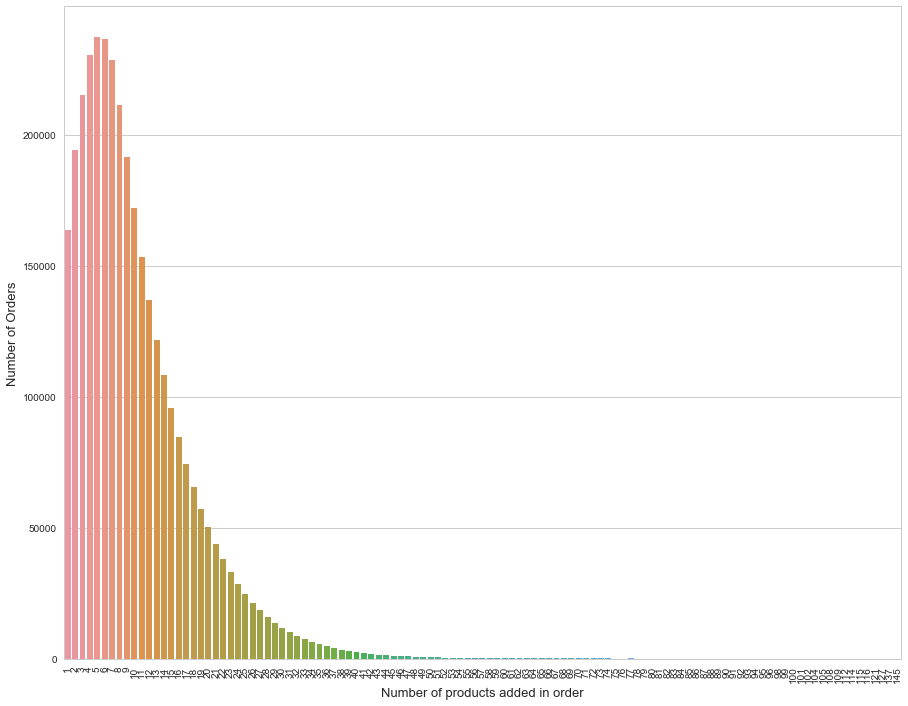

In [221]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

## Most Ordered Item or Product

In [222]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


Fruits like banana , strawberries...are the most ordered products.



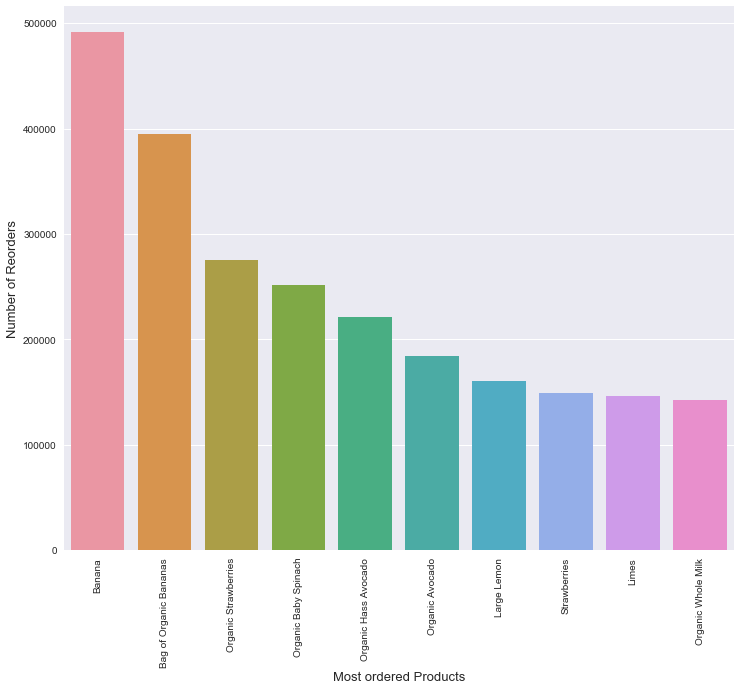

In [223]:
grouped  = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

In [224]:
no_products_bought = order_products_all.groupby('order_id')['product_id'].count()
no_products_bought.describe()

count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64

print ( "Averagely , users order ",(str(int(no_products_bought.mean()))) , " items per order")
print ("In median , users order ", (str(int(no_products_bought.median()))), " items per order")
print ("Minimum users order ",(str(int(no_products_bought.min()))), " items per order")
print ("Maximum users order ",(str(int(no_products_bought.max()))), " items per order")

## Reorder Frequency

In [225]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


**59 %** of ordered products are previously ordered by customers.

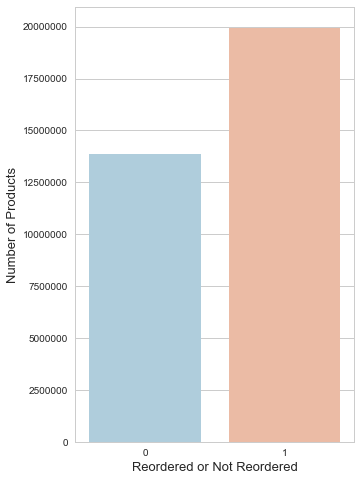

In [226]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## Most Reordered Products

Which products are usually reordered ?

In [227]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


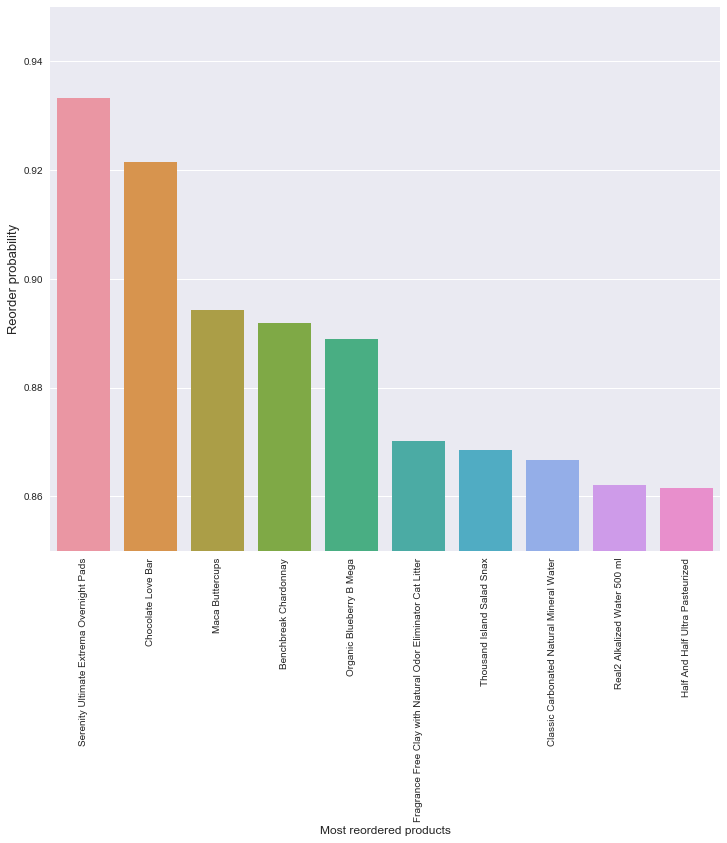

In [228]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

Let's explore now the orders.csv file

In [229]:
print("The orders data size is : ", orders.shape)
print("Columns in orders data  are : ",  orders.columns.values)

The orders data size is :  (3421083, 7)
Columns in orders data  are :  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [230]:
#display first five rows of our dataset.

orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [231]:
orders_na = (orders.isnull().sum() / len(orders)) * 100
#orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.027594
dtype: float64

The only feature with missing values is days_since_prior_order with **6.028 %** missing

## Time of orders

Hours of Order in a day

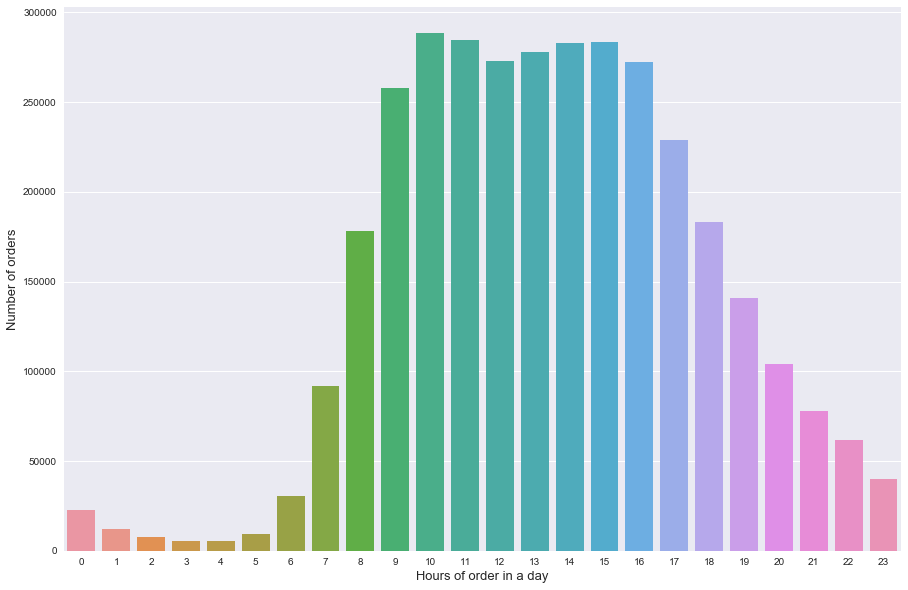

In [232]:
grouped = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

People mostly order between 8 and 19 (anonimyzed hours and probably between 8 a.m and 7 p.m.)

# Days of Orders in a week:

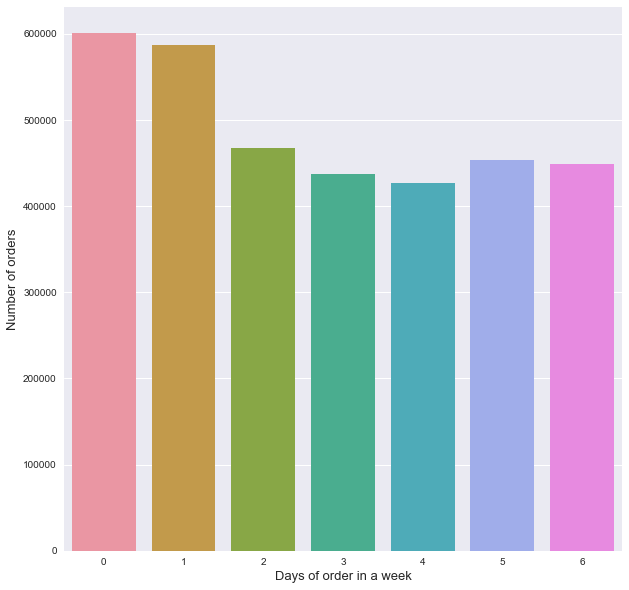

In [26]:
grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

People usually order at days 0 and 1 (anonimyzed days and probably the week end)

Period of Reorders:

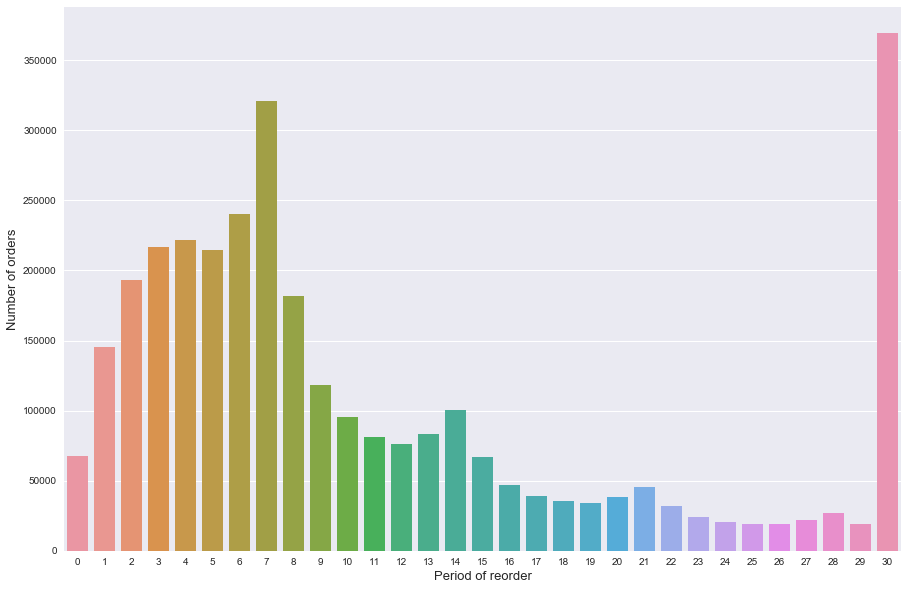

In [27]:
grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

Number and ratio of orders from the three datasets (prior, train, test).

In [28]:
grouped = orders.groupby("eval_set")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.939724
1,test,75000,0.021923
2,train,131209,0.038353


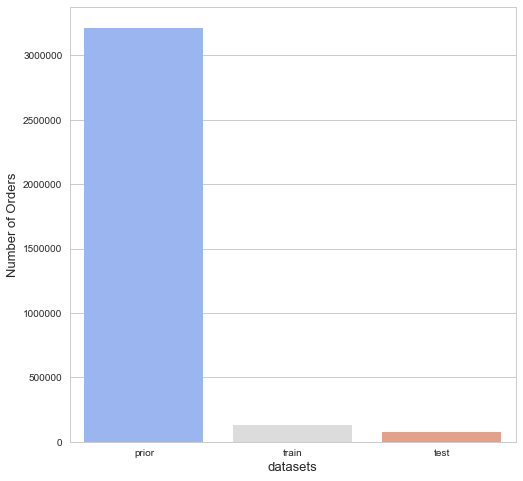

In [29]:
grouped  = grouped.groupby(['eval_set']).sum()['Total_orders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()

## Orders made by each customer

Let's check the number of orders made by each costumer in the whole dataset.

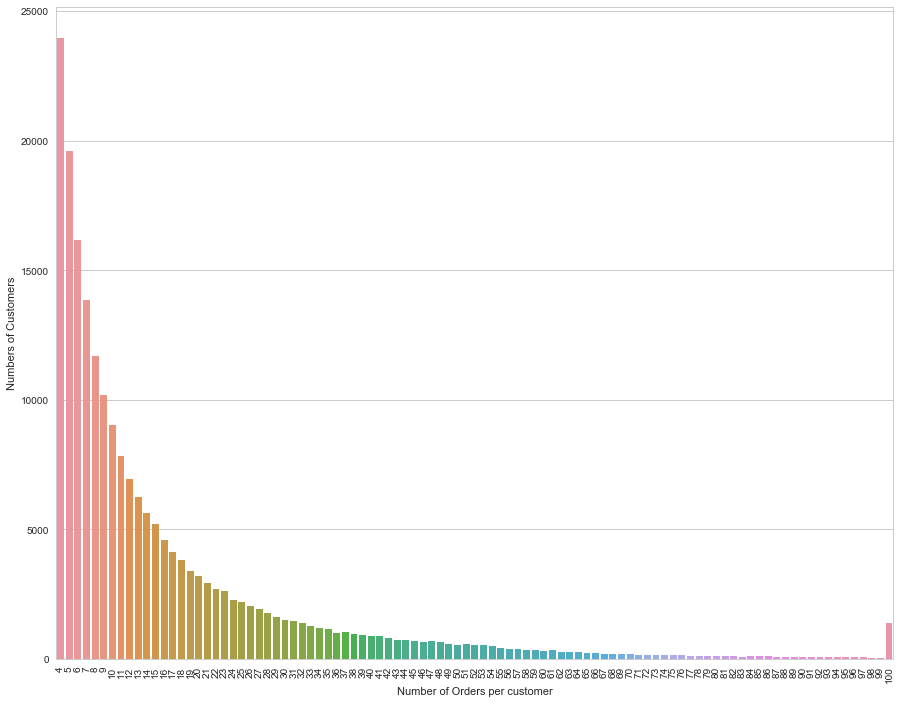

In [30]:
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(grouped.index, grouped.user_id)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

We can observe that most customers made 4 orders. There are around 1250 customers who purchased 100 items



Now let's explore the items datasets (products, departments and aisles files.)

In [31]:
#display first five rows of our dataset.
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [32]:
#display first five rows of our dataset.
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [33]:
#display first five rows of our dataset.
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Now let's combine them in a single dataframe

In [34]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


# Most important Departments (by number of products)

In [35]:
grouped = items.groupby("department")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132084
20,snacks,6264,0.126067
16,pantry,5371,0.108095
3,beverages,4365,0.087848
10,frozen,4007,0.080643
7,dairy eggs,3449,0.069413
11,household,3085,0.062087
6,canned goods,2092,0.042103
9,dry goods pasta,1858,0.037393
19,produce,1684,0.033891


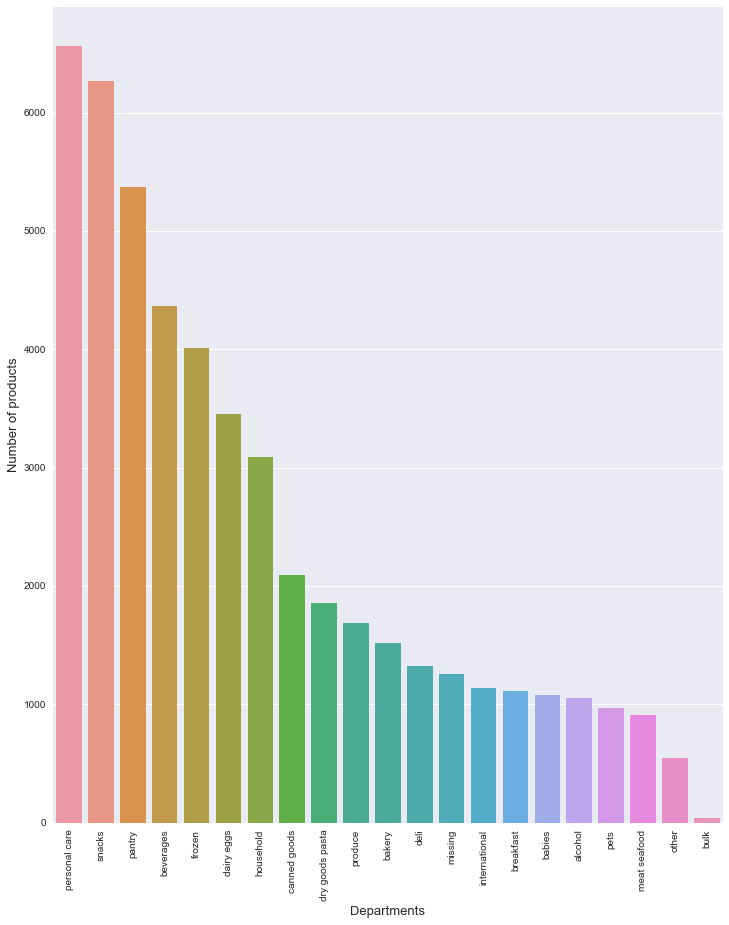

In [36]:
grouped  = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

## Most important Aisles in each Department (by number of Products)

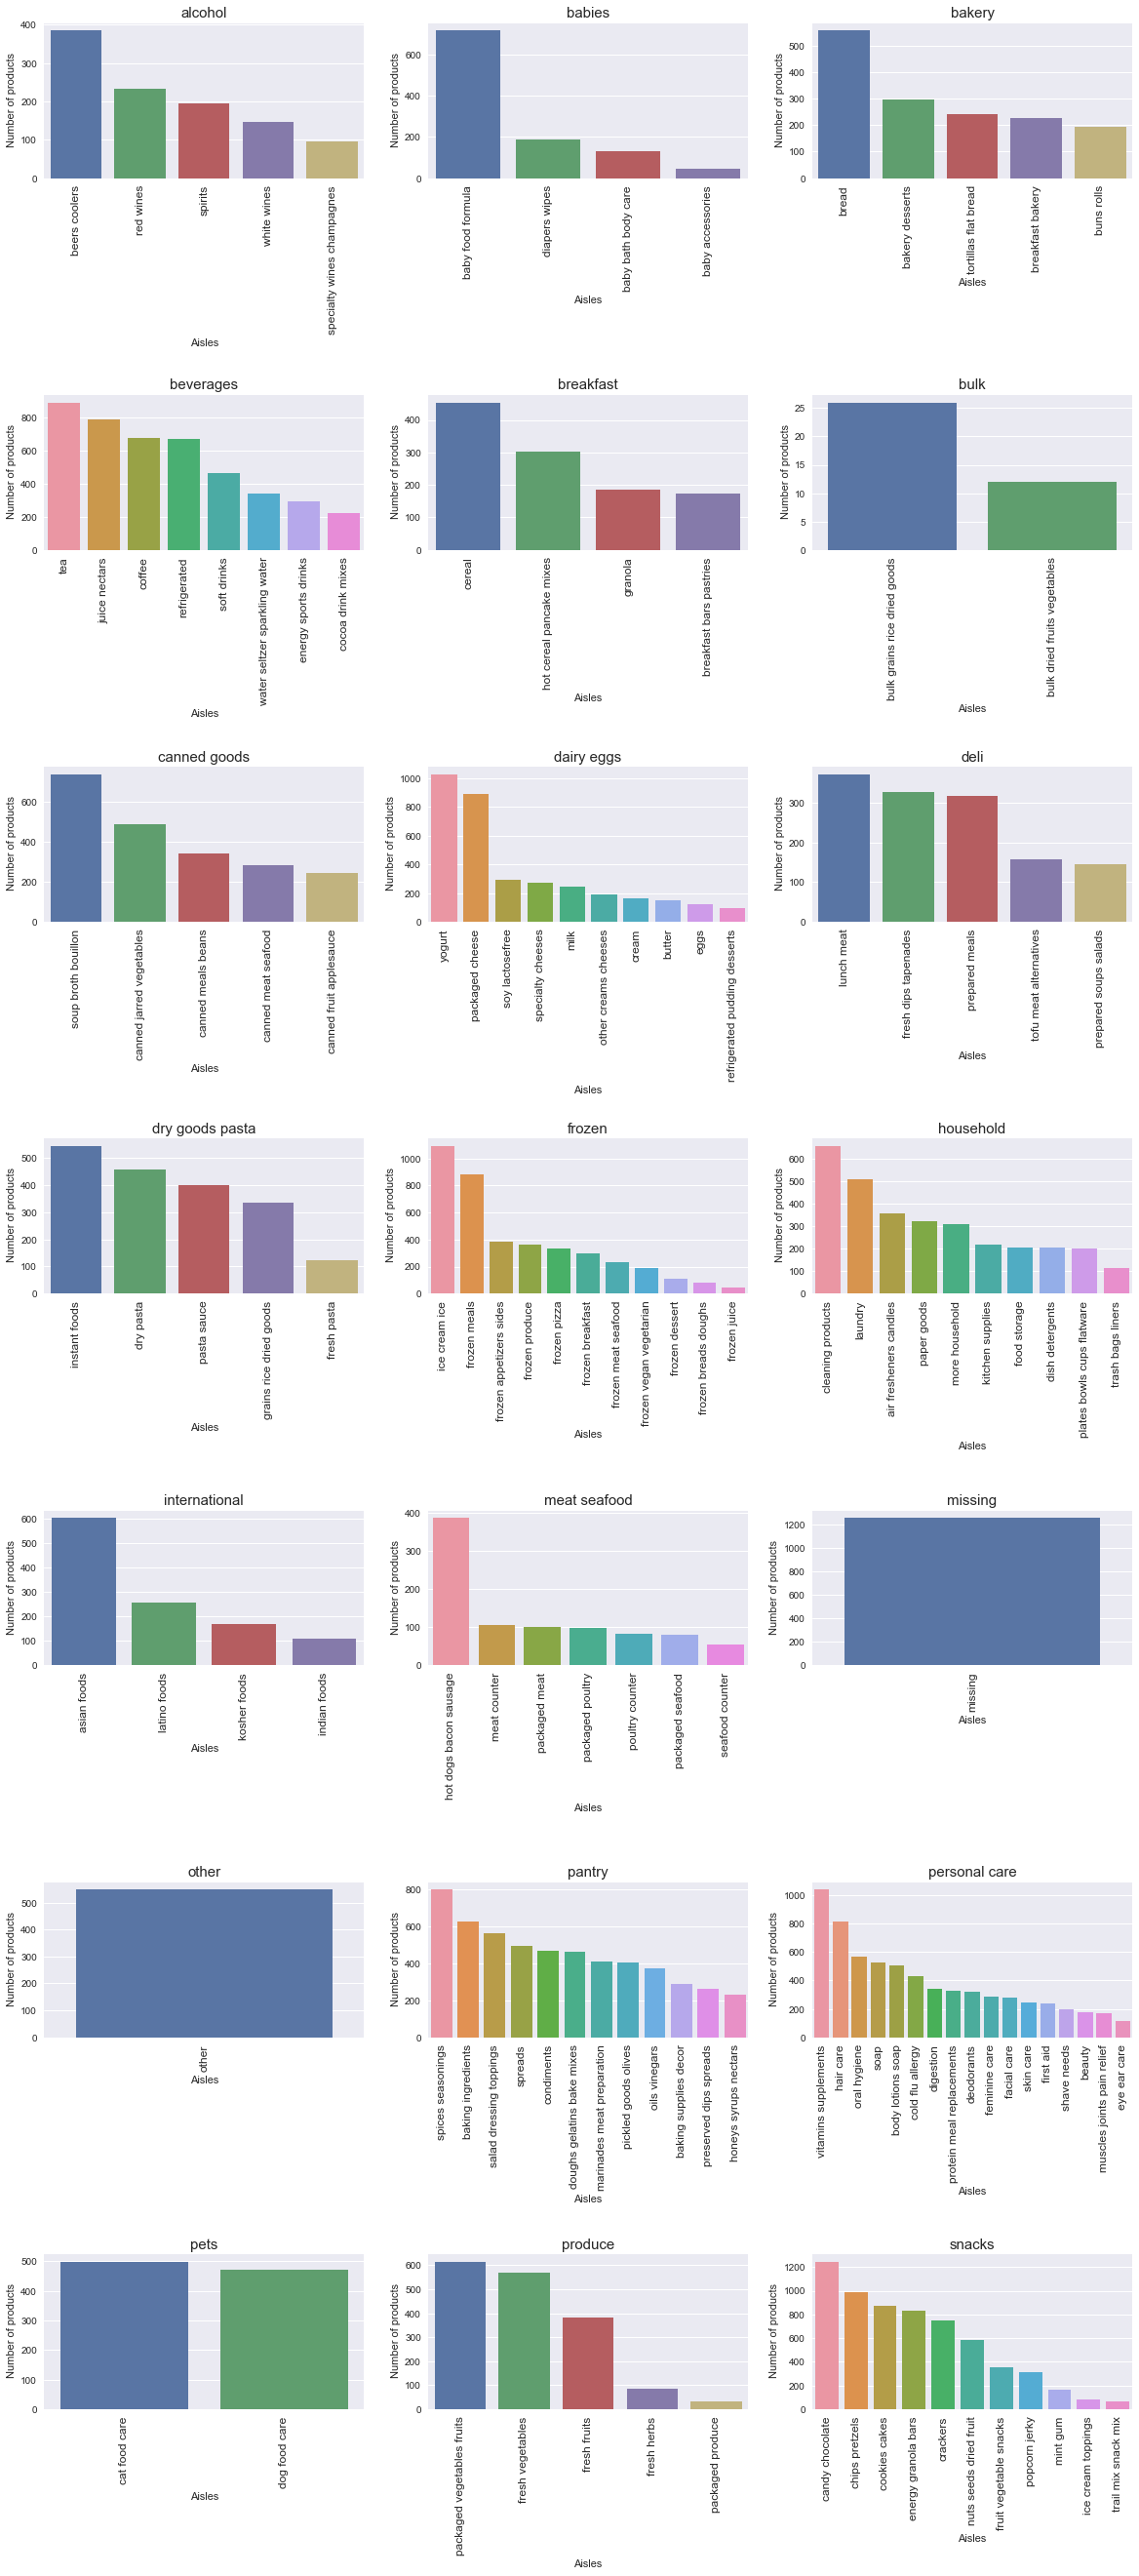

In [37]:
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

# Most important Aisles over all Departments (by number of Products)

In [38]:
grouped = items.groupby("aisle")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.025318
18,candy chocolate,1246,0.025076
71,ice cream ice,1091,0.021957
130,vitamins supplements,1038,0.020890
133,yogurt,1026,0.020649
25,chips pretzels,989,0.019904
125,tea,894,0.017992
93,packaged cheese,891,0.017932
59,frozen meals,880,0.017711
31,cookies cakes,874,0.017590


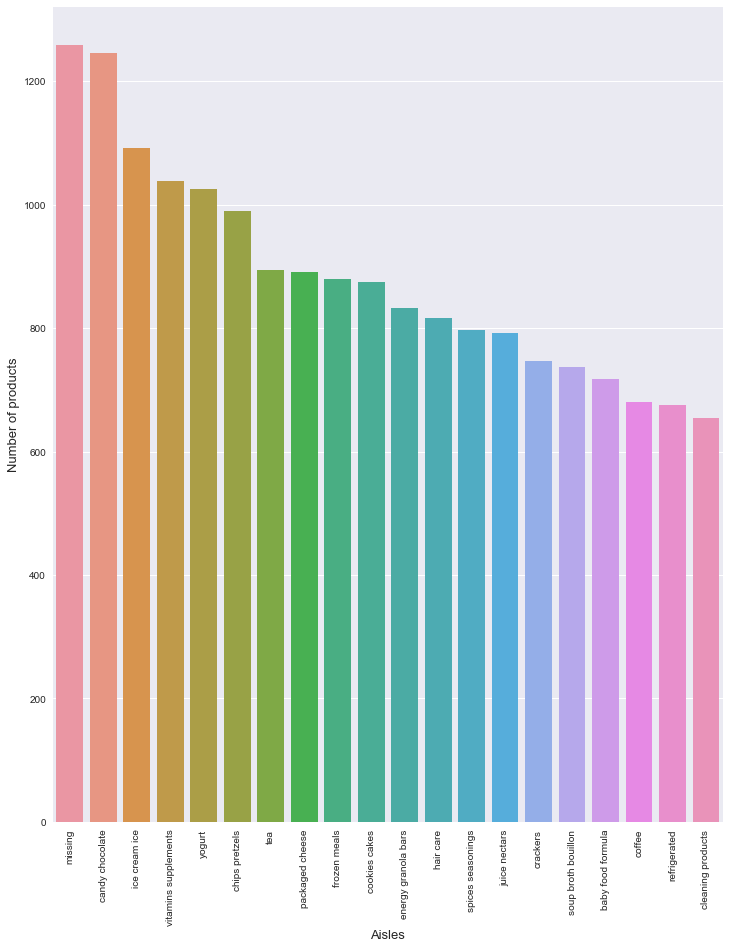

In [39]:
grouped  = grouped.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

# What are customers' favorite Departments and Aisles ?

In [40]:
users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')

users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

## Best Selling Departments (number of Orders)

In [41]:
grouped = users_flow.groupby("department")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,department,Total_orders,Ratio
19,produce,409087,0.295451
7,dairy eggs,217051,0.156759
20,snacks,118862,0.085845
3,beverages,114046,0.082366
10,frozen,100426,0.072530
16,pantry,81242,0.058675
2,bakery,48394,0.034951
6,canned goods,46799,0.033799
8,deli,44291,0.031988
9,dry goods pasta,38713,0.027959


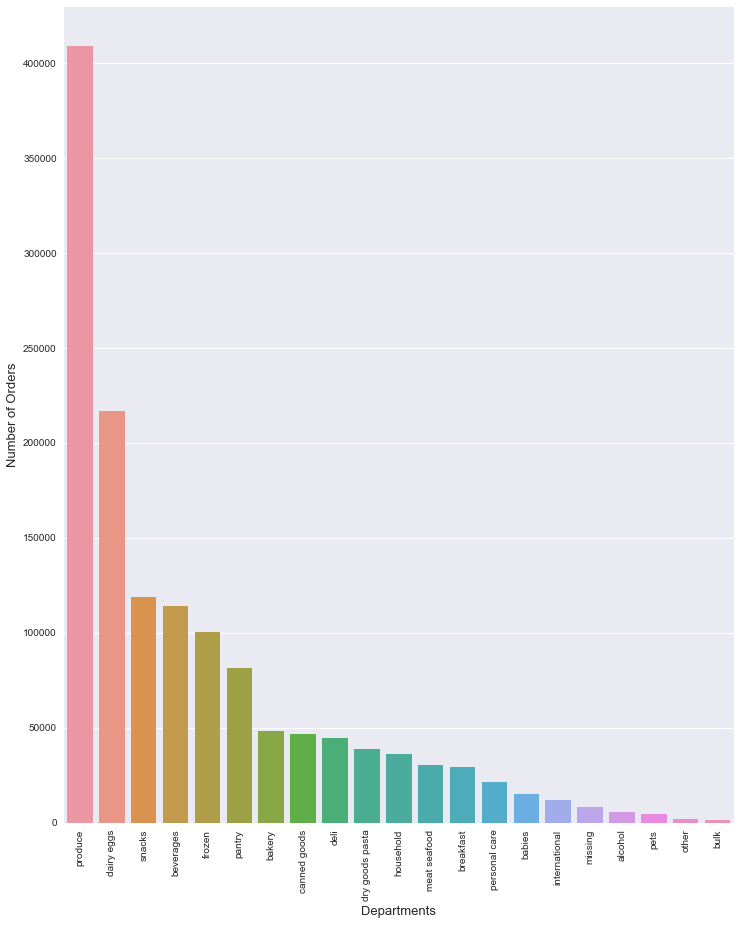

In [42]:
grouped  = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

# Best Selling Aisles in each Department (number of Orders)

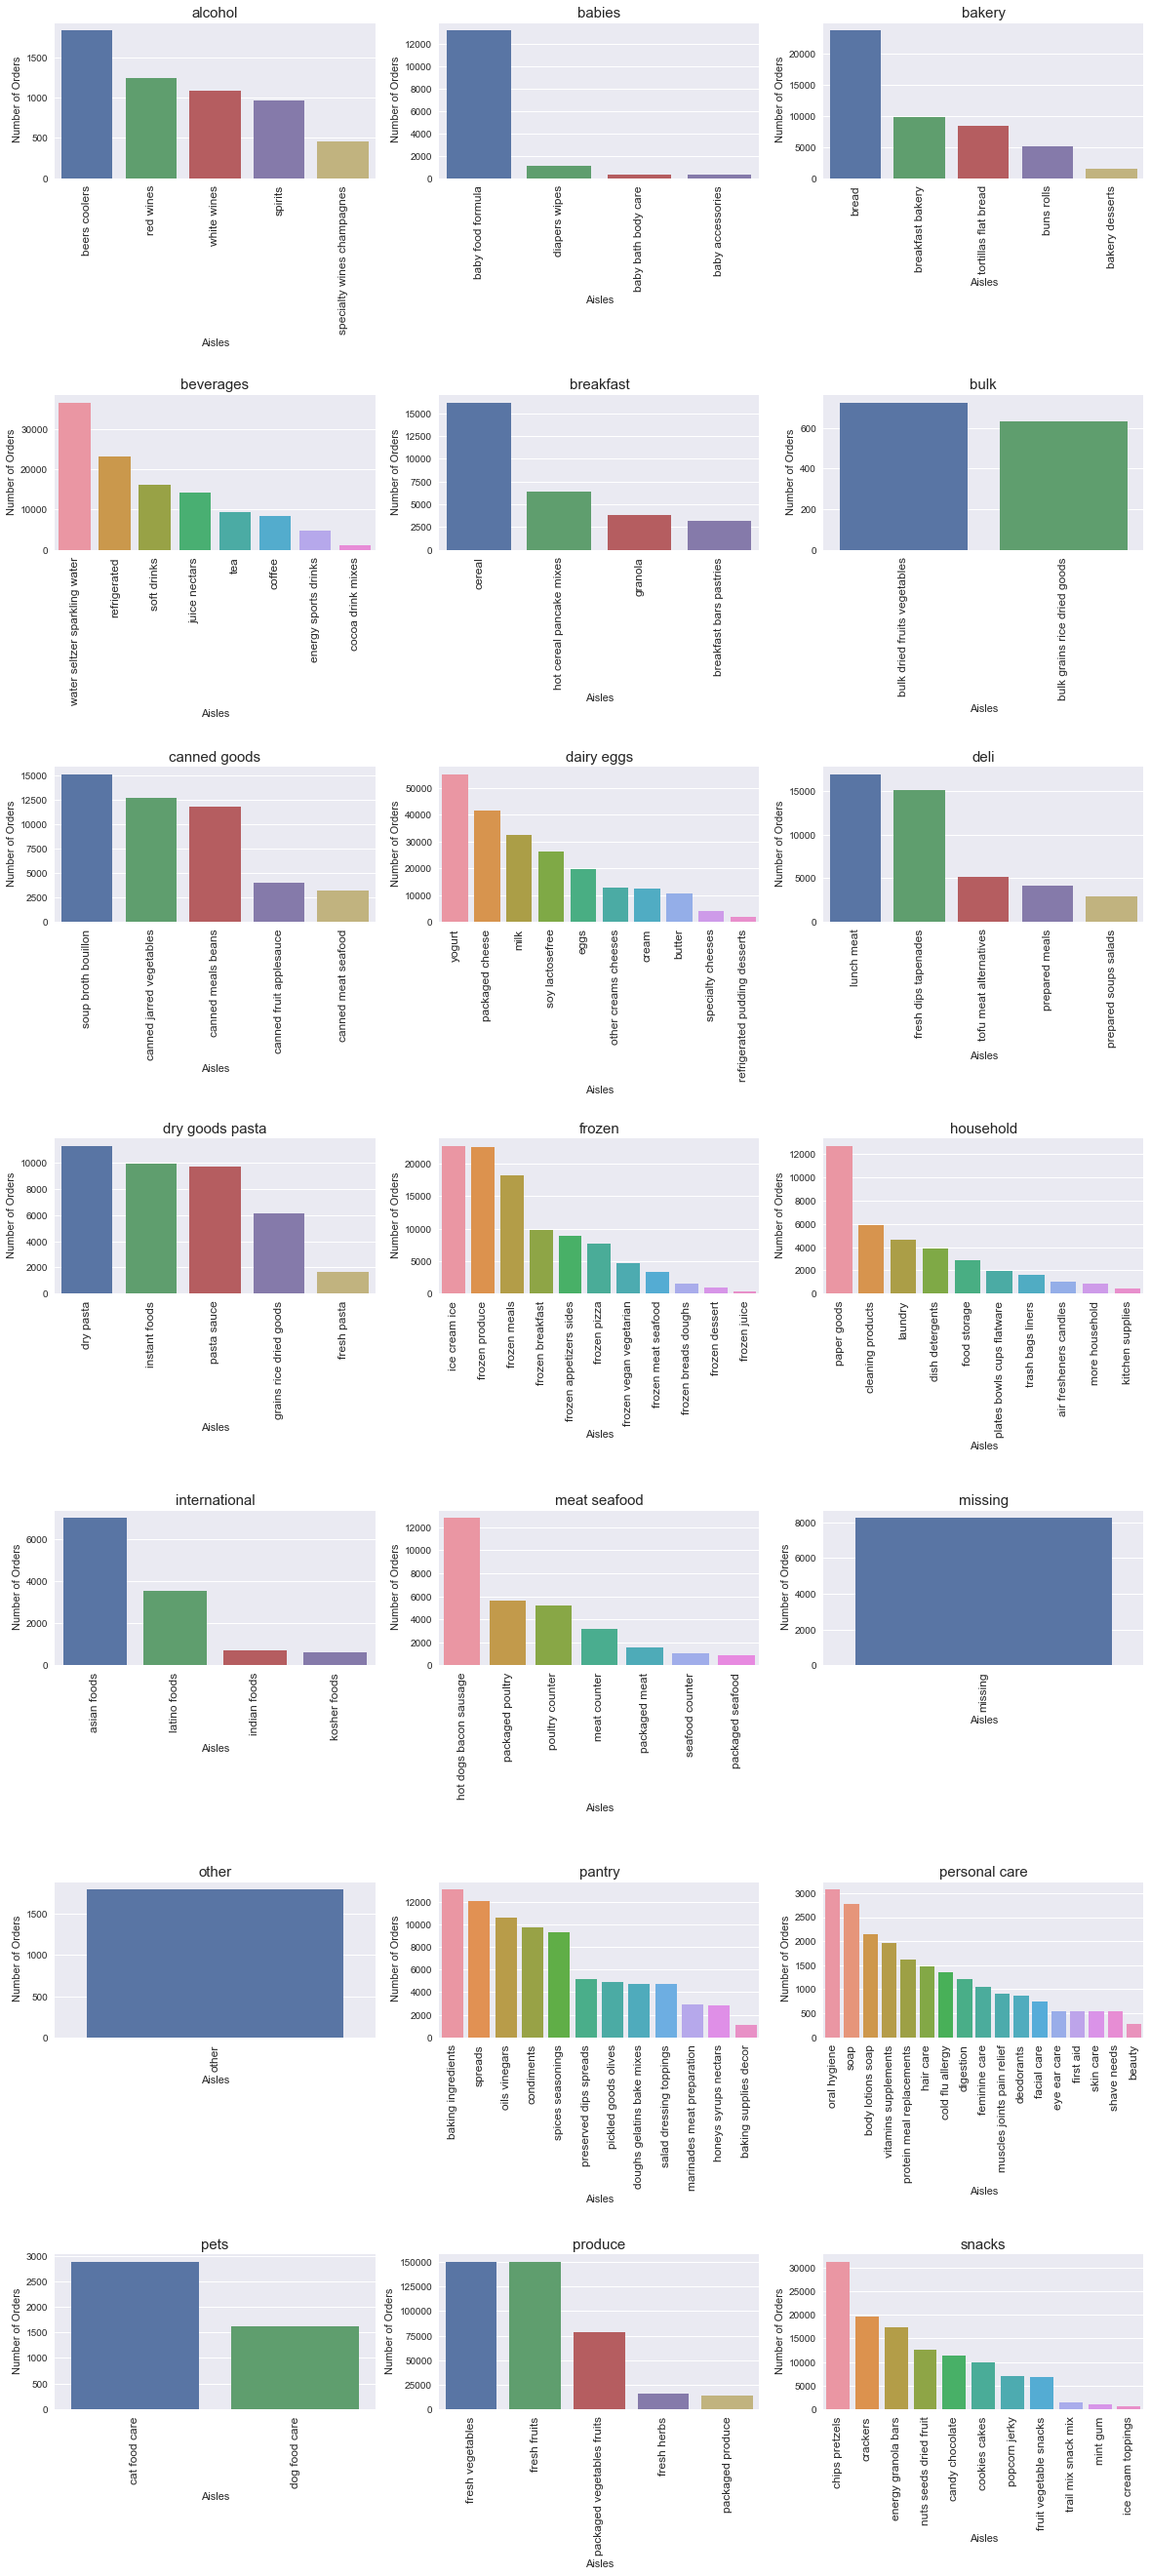

In [43]:
grouped = users_flow.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

# Best Selling Aisles over all Departments.

In [44]:
grouped = users_flow.groupby("aisle")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
53,fresh vegetables,150609,0.108773
50,fresh fruits,150473,0.108675
98,packaged vegetables fruits,78493,0.056689
133,yogurt,55240,0.039896
93,packaged cheese,41699,0.030116
131,water seltzer sparkling water,36617,0.026446
83,milk,32644,0.023576
25,chips pretzels,31269,0.022583
119,soy lactosefree,26240,0.018951
11,bread,23635,0.017070


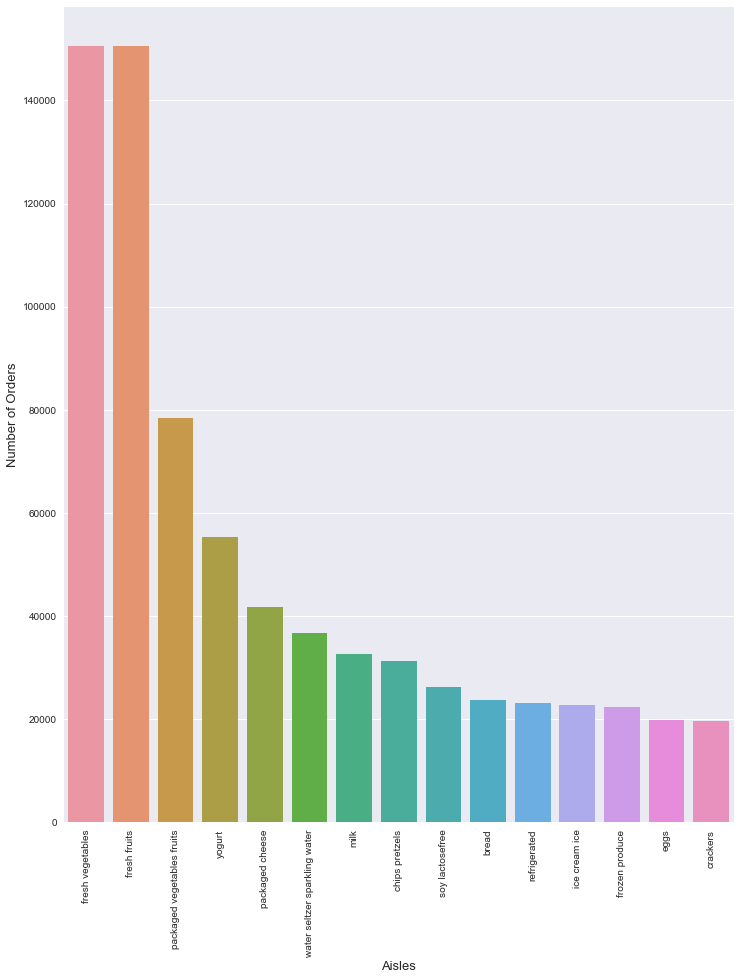

In [45]:
grouped  = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

To predict which previously purchased products will be in a user’s next order

For data exploration, please refer to this notebook.

# Step 1 We will start with reading the orders file.

In [233]:
data_path = "../Assignment1_Data/"
orders_df = pd.read_csv(data_path + "orders.csv", usecols=["order_id","user_id","order_number"])

In [234]:
orders_df.head()

,order_id,user_id,order_number
0,2539329,1,1
1,2398795,1,2
2,473747,1,3
3,2254736,1,4
4,431534,1,5


Since the objective is to predict which previously purchased products will be in next order, let us first get the list of all products purchased by the customer.

# Step 2 Create data frame with old purchase

In [235]:
# read the prior order file #
prior_df = pd.read_csv(data_path + "order_products__prior.csv")

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()
#prior_df.to_csv("prior_df1.csv", index=False)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


# Step 3 Create data frame with latest purchase 

In [93]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


# Step 4. Get count of Number of reorders 

In [236]:


# get the count of each product and number of reorders by the customer #
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


# Step 5 merge the prior df with latest df 

In [237]:




prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


Read the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.

In [239]:
orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv(data_path + "order_products__train.csv", usecols=["order_id"])
train_df.head()


,order_id
0,1
1,1
2,1
3,1
4,1


# Step 6 Get distinct order id in train_df. This will help in joining the data frame with orders 

In [240]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


# join with Orders data frame

In [241]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [242]:
test_df = pd.read_csv(data_path + "sample_submission.csv", usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


# Step 7 : Prepare test data frames

In [244]:

print(train_df.shape, test_df.shape)


(131209, 2) (75000, 2)


# Step 8:  Merge the train and test data with prior_df to get the products purchased previously by the customer.

In [245]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN


In [246]:

test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0


In [247]:
print(train_df.shape, test_df.shape)

(8474661, 6) (4833292, 6)


In [248]:
products_df = pd.read_csv(data_path + "products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


# Step 9 : Add more features to training data from Products data frame

In [249]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [250]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,NaN,100,21
1,657743,16994,1283,1,0,NaN,100,21
2,834223,92628,1283,1,0,NaN,100,21
3,1446886,75870,1283,1,0,NaN,100,21
4,1518981,118458,1283,3,2,NaN,100,21


In [251]:

#del products_df
print(train_df.shape, test_df.shape)

(8474661, 8) (4833292, 8)


# Now we have all the products that has been purchased previously by the customer along with some characteristics / featrures. So we can use the train dataset to populate the target variable i.e., whether the product has been reordered in the next order.

In [252]:
train_y_df = pd.read_csv(data_path + "order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
#print(train_y_df.reordered.sum())
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)
#print(train_df.reordered.sum())
#del train_y_df

(8474661, 9)


In [253]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [254]:
 import pandas as pd

In [255]:
X=train_df.drop('reordered',axis=1)

In [256]:
X.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [257]:

Y =train_df['reordered']

In [258]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: reordered, dtype: float64

# Step 10: split data into train and test sets

In [190]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)


In [195]:
model = XGBClassifier()

# Step 11: Train the model using XGBClassifier

In [196]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [197]:
y_pred = model.predict(X_test)

In [198]:
predictions = [round(value) for value in y_pred]

In [199]:
accuracy = accuracy_score(y_test, predictions)

# Step: 11 d : Print Accuracy for the model

In [200]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.43%


In [202]:
# target variable for train set #
train_y = train_df.reordered.values

# dataframe for test set predictions #
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns #
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'reordered'

# Step 12: Create XGb function

In [203]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

# Step 13: Run the XGB function on training np array

In [205]:
# run the xgboost model #
pred = runXGB(train_df, train_y, test_df)
#del train_df, test_df

# use a cut-off value to get the predictions #
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.ix[out_df["Pred"].astype('int')==1]

In [206]:
# when there are more than 1 product, merge them to a single string #
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]



# Step 14: Load result in the output file

In [208]:
# read the sample csv file and populate the products from predictions #
sub_df = pd.read_csv(data_path + "sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# when there are no predictions use "None" #
sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv("xgb_starter_3450.csv", index=False)

In [259]:
# Conclusion: 
    